In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
# from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import mobilenet_v3

In [17]:
img_height, img_width = (200, 200)
IMG_SIZE = (img_height, img_width)
IMG_SIZE_WITH_RGB = IMG_SIZE+(3,)
batch_size = 32

data_directory = "dataset"

In [18]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="training",
    validation_split=0.2,
    seed=69420,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 685 files belonging to 8 classes.
Using 548 files for training.


In [19]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="validation",
    validation_split=0.2,
    seed=69420,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 685 files belonging to 8 classes.
Using 137 files for validation.


In [20]:
train_data.class_names

['1_polyethylene_PET',
 '2_high_density_polyethylene_PE-HD',
 '3_polyvinylchloride_PVC',
 '4_low_density_polyethylene_PE-LD',
 '5_polypropylene_PP',
 '6_polystyrene_PS',
 '7_other_resins',
 '8_no_plastic']

In [21]:
class_names = train_data.class_names

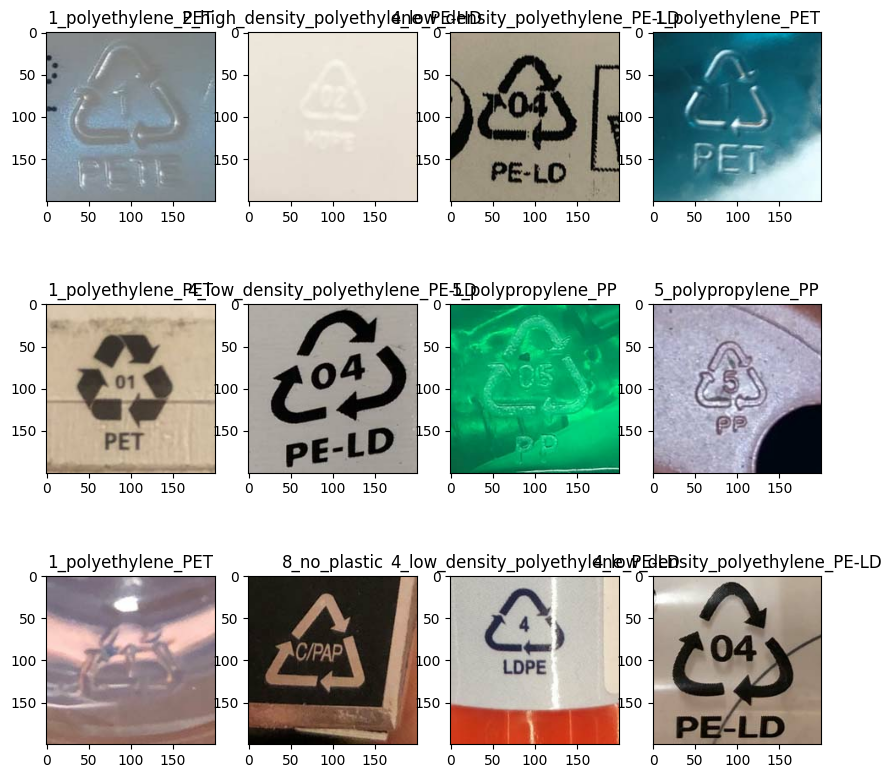

In [22]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range (12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = class_names[label_batch[i]]
    plt.title(label)


In [24]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE_WITH_RGB,
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

In [25]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(len(class_names))

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomRotation(40),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SIZE_WITH_RGB),
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input),
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    prediction_layer
])


learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, None, None, 3)     0         
                                                                 
 lambda_1 (Lambda)           (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                

In [29]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(validation_data)

5/5 [==============================] - 5s 510ms/step - loss: 2.9526 - accuracy: 0.0365


In [30]:
loss0, accuracy0

(2.95255184173584, 0.036496348679065704)

In [31]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)

Epoch 1/300
 9/18 [==============>...............] - ETA: 1:03 - loss: 2.4566 - accuracy: 0.1667

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# import pickle

# model_file_path = "MobileNetV2_1e-4_80%.pkl"
# with open(model_file_path, "wb") as file:
#     pickle.dump(model, file)

# import os
# if os.path.isfile(model_file_path):
#     file_size = os.path.getsize(model_file_path)
#     print(f"Model successfully dumped. File size: {file_size} bytes.")
# else:
#     print("Model dumping failed.")